In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors
from rdkit.Chem.AllChem import GetMorganGenerator
import seaborn as sns

In [13]:
df = pd.read_csv('dataset.csv')

In [14]:
print(f'Number of reactions: {len(df)}')
print(f'Number of reactants 1: {len(df["reactant_1"].unique())}')
print(f'Number of reactants 2: {len(df["reactant_2"].unique())}')
print(f'Number of reactants 3: {len(df["reactant_3"].unique())}')
print(f'Number of solvents: {len(df["solvent"].unique())}')
print(f'Number of catalysts 1: {len(df["catalyst_1"].unique())}')
print(f'Number of catalysts 2: {len(df["catalyst_2"].unique())}')
print(f'Number of products: {len(df["product_R"].unique())}')
print(f'Number of undesired products: {len(df["product_undesired_R"].unique())}')

Number of reactions: 1430
Number of reactants 1: 10
Number of reactants 2: 1
Number of reactants 3: 1
Number of solvents: 1
Number of catalysts 1: 11
Number of catalysts 2: 13
Number of products: 10
Number of undesired products: 10


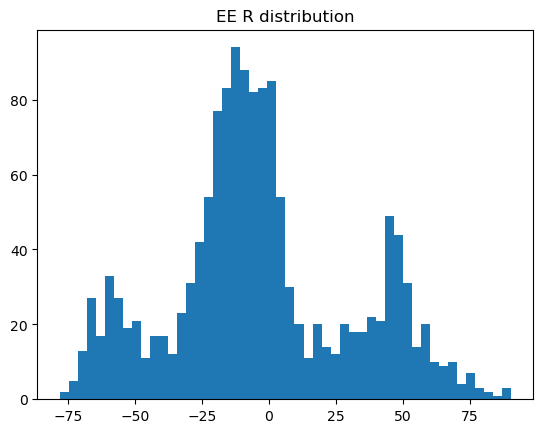

In [15]:
plt.title('EE R distribution')
plt.hist(df['ee_R'], bins=50)
plt.show()

In [16]:
df['ee_R'].quantile(0.99)

np.float64(74.10400077819826)

In [17]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

print(f'Total combination count: {len(reactant_1_pool) * len(catalyst_1_pool) * len(catalyst_2_pool)} (size of the dataset:{len(df)})')

Total combination count: 1430 (size of the dataset:1430)


In [18]:
fpgen = GetMorganGenerator(radius=2,fpSize=1024)

reactant_1_descriptors = SmilesToDescriptors(fpgen, reactant_1_pool)
catalyst_1_descriptors = SmilesToDescriptors(fpgen, catalyst_1_pool)
catalyst_2_descriptors = SmilesToDescriptors(fpgen, catalyst_2_pool, sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target = NumericalTarget(
    name="ee_R",
    mode="MAX",
)

objective = SingleTargetObjective(target=target)

df_lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R']]
df_lookup.head(2)

#print(searchspace)

,reactant_1,catalyst_1,catalyst_2,ee_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.63
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.66


In [20]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5


lookup = df_lookup  # some reasonable lookup, e.g. a Callable

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

botorch_rdm_recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

fps_recommender = FPSRecommender()
random_recommender = RandomRecommender()

botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)
botorch_rdm_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_rdm_recommender)

fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=fps_recommender)
random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"Botorch FPS": botorch_fps_campaign,"Botorch rdm": botorch_rdm_campaign, "Random": random_campaign, "FPS": fps_campaign}

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 20%|##        | 4/20 [03:16<13:06, 49.14s/it]c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarn

In [21]:
results

,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,ee_R_Measurements,ee_R_IterBest,ee_R_CumBest
0,Botorch FPS,0,0,1,[-8.270000457763672],-8.270000,-8.270000
1,Botorch FPS,0,1,2,[70.7699966430664],70.769997,70.769997
2,Botorch FPS,0,2,3,[-8.460000038146973],-8.460000,70.769997
3,Botorch FPS,0,3,4,[44.22999954223633],44.230000,70.769997
4,Botorch FPS,0,4,5,[-10.670000076293944],-10.670000,70.769997
...,...,...,...,...,...,...,...
1995,FPS,4,95,96,[-16.850000381469727],-16.850000,79.949997
1996,FPS,4,96,97,[-55.7599983215332],-55.759998,79.949997
1997,FPS,4,97,98,[-0.4199999868869781],-0.420000,79.949997
1998,FPS,4,98,99,[0.4399999976158142],0.440000,79.949997


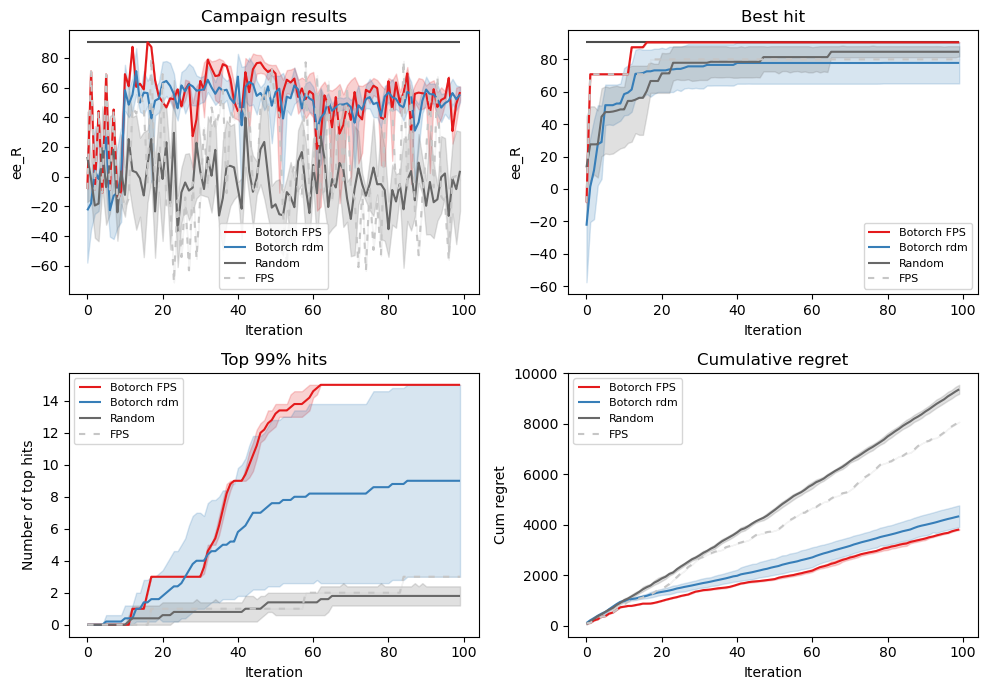

In [22]:
from utils import plot_results

plot_results(results, lookup, figure_name= 'init_bo.png', nbr_controls=2)
